In [1]:
%cd ..

c:\Users\justi\coding\Uni\MA


In [2]:
from enum import Enum
import librosa
import numpy as np
from evoaudio.fitness import fitness_cached
from evoaudio.individual import BaseIndividual
from evoaudio.population import Population
from evoaudio.target import Target
from evoaudio.sample_library import SampleLibrary
from parsing.arff_parsing import parse_arff

c:\Users\justi\miniconda3\envs\ma\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sample_lib = SampleLibrary()

Loading samples: 100%|██████████| 6826/6826 [00:09<00:00, 687.48it/s] 


In [4]:
pop = Population.from_file("./experiments/tiny_aam/300_1_3000_0.05_5_10_1_20_0.9954_15_20_1sec_repeat/0/0001.pkl", expand=True, sample_lib=sample_lib)
annotations = parse_arff("./audio/tiny_aam/annotations/0001_onsets.arff")
target_mix, target_sr = librosa.load("./audio/tiny_aam/audio-mixes-mp3/0001_mix.mp3")
onsets = [int(round(float(onset_time) * target_sr)) for onset_time in annotations.keys()]
target = Target(target_mix, onsets)

In [5]:
def get_sample_retry(instrument, pitch):
    sample = None
    while sample is None:
        try:
            sample = sample_lib.get_sample(
                instrument=instrument, 
                style=sample_lib.get_random_style_for_instrument(instrument), 
                pitch=pitch
            )
        except:
            continue
    return sample

def annotation_to_individual(annotation):
    samples = []
    for tup in annotation:
        instrument = tup[0]
        pitch = int(tup[1].replace("+", ""))
        samples.append(get_sample_retry(instrument, pitch))
    ind = BaseIndividual()
    ind.samples = samples
    return ind

class class_mode(Enum):
    INSTRUMENTS = 0
    PITCHES = 1
    COMBINED = 2

def extract_instruments(individual:BaseIndividual):
    seen_instruments = []
    for sample in individual.samples:
        if sample.instrument not in seen_instruments:
            seen_instruments.append(sample.instrument)
    return seen_instruments

def extract_pitches(individual:BaseIndividual):
    seen_pitches = []
    for sample in individual.samples:
        if sample.pitch not in seen_pitches:
            seen_pitches.append(sample.pitch)
    return seen_pitches

def extract_samples(individual:BaseIndividual):
    seen_samples = []
    for sample in individual.samples:
        if (sample.instrument, sample.pitch) not in seen_samples:
            seen_samples.append((sample.instrument, sample.pitch))
    return seen_samples

def jaccard_error(population:Population, annotations:dict, mode:class_mode):
    """Iteratively calculates the jaccard error for each onset, then returns the mean.

    Parameters
    ----------
    population : Population
        candidate population.
    annotations : dict
        extracted annotations in style {onset: [(instrument1, pitch1), (instrument2, pitch2), ...]}
    mode : class_mode
        whether to calculate the error for instrument, pitch or combined approximation

    Returns
    -------
    float
        mean jaccard error across all onsets.
    """
    time_onsets = list(annotations.keys())
    jaccard_errors_per_onset = []
    for i, onset in enumerate(population.archive):
        individual = population.archive[onset].individual
        time_onset = time_onsets[i]
        match mode:
            case class_mode.INSTRUMENTS:
                extracted_features = extract_instruments(individual)
                annotated_features = [annotation[0] for annotation in annotations[time_onset]]
            case class_mode.PITCHES:
                extracted_features = extract_pitches(individual)
                annotated_features = [annotation[1] for annotation in annotations[time_onset]]
            case class_mode.COMBINED:
                extracted_features = extract_samples(individual)
                annotated_features = annotations[time_onset]
        intersection = [instrument for instrument in extracted_features if instrument in annotated_features]
        union = list(set(extracted_features) | set(annotated_features))
        false_positives = set(extracted_features).symmetric_difference(intersection)
        false_negatives = set(annotated_features).symmetric_difference(intersection)
        jaccard_errors_per_onset.append((len(false_positives) + len(false_negatives)) / len(union))
    return jaccard_errors_per_onset

In [6]:
true_fitnesses = []
record_fitnesses = []
for i, time in enumerate(list(annotations.keys())[:-1]):
    onset = list(pop.archive.keys())[i]
    record = pop.archive[onset]
    annotation = annotations[time]
    annotated_ind = annotation_to_individual(annotation)
    true_fitness = (fitness_cached(annotated_ind, target.abs_stft_per_snippet[onset]))
    annotated_ind.fitness = true_fitness
    true_fitnesses.append(true_fitness)
    record_fitnesses.append(record.fitness)
distances = np.array(true_fitnesses) - np.array(record_fitnesses)
bad_distances = [distance for distance in distances if distance > 0]
print(len(bad_distances) / len(distances))

0.9103260869565217


In [7]:
instrument_errors = jaccard_error(pop, annotations, class_mode.INSTRUMENTS)
pitch_errors = jaccard_error(pop, annotations, class_mode.PITCHES)
combined_errors = jaccard_error(pop, annotations, class_mode.COMBINED)
print(instrument_errors)

[1.0, 0.8, 0.8, 0.6666666666666666, 0.8, 0.8, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 0.8, 0.8, 0.8571428571428571, 1.0, 0.8, 0.8571428571428571, 0.8571428571428571, 0.8, 0.8333333333333334, 1.0, 0.8333333333333334, 1.0, 0.8, 0.8, 0.8, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 0.8, 0.8571428571428571, 1.0, 0.8, 0.8, 0.8, 0.8, 1.0, 0.6666666666666666, 0.6666666666666666, 1.0, 0.8333333333333334, 0.8, 0.8, 0.6666666666666666, 0.8, 0.8, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.8, 0.8571428571428571, 1.0, 0.8, 1.0, 0.8571428571428571, 0.8, 0.8, 1.0, 0.8333333333333334, 1.0, 0.8, 0.8, 0.8, 0.8, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 0.8, 0.8571428571428571, 1.0, 0.8, 0.8, 0.8, 0.8, 0.8, 0.6666666666666666, 0.6666666666666666, 1.0, 1.0, 0.8, 0.8, 0.8, 0.8, 0.8, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 0.8571428571428571, 0.8333333333333334, 1.0,

(0.0, 2.0)

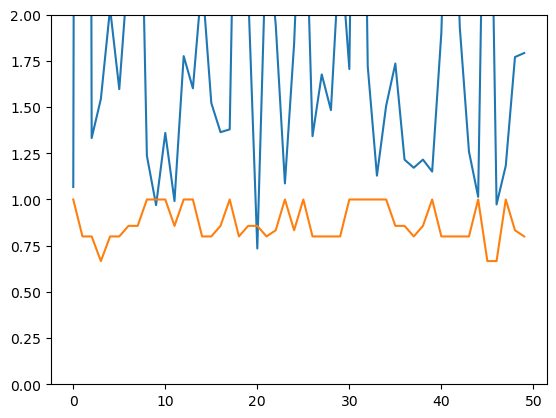

In [8]:
import matplotlib.pyplot as plt
plt.plot(true_fitnesses[:50])
plt.plot(instrument_errors[:50])
plt.ylim((0, 2))

## Investigating other Fitness Function

In [9]:
ind = annotation_to_individual(annotations[list(annotations.keys())[0]])
mix = ind.to_mixdown()
mfcc = librosa.feature.mfcc(y=mix, n_mfcc=13)
mfcc_avg = np.mean(mfcc, axis=1)
mfcc_avg.shape

(13,)

In [19]:
def beta_divergence(beta, x, y):
    def d(beta, x, y):
        if beta == 0:
            return x / y - np.log(x/y) - 1
        elif beta == 1:
            return x * np.log(x/y) + (y - x)
        else:
            return (1 / (beta * (beta - 1))) * (x**beta + (beta - 1) * y**beta - beta * x * y**(beta - 1))
    inner_sum = [d(beta, x[i], y[i]) for i in range(len(x))]
    return np.sum(inner_sum)

def mfcc_fitness(x, y):
    mfcc_x = librosa.feature.mfcc(y=x, n_mfcc=13)
    mfcc_y = librosa.feature.mfcc(y=y, n_mfcc=13)
    return beta_divergence(2, np.mean(mfcc_x, axis=1), np.mean(mfcc_y, axis=1))

In [20]:
# Repeat above calculations with mfcc
true_fitnesses_mfcc = []
record_fitnesses_mfcc = []
for i, time in enumerate(list(annotations.keys())[:-1]):
    onset = list(pop.archive.keys())[i]
    record = pop.archive[onset]
    annotation = annotations[time]
    annotated_ind = annotation_to_individual(annotation)
    true_fitness_mfcc = (mfcc_fitness(annotated_ind.to_mixdown(), target.y[onset:onsets[i+1]]))
    annotated_ind.fitness = true_fitness_mfcc
    true_fitnesses_mfcc.append(true_fitness_mfcc)
    record_fitnesses_mfcc.append(mfcc_fitness(record.individual.to_mixdown(), target.y[onset:onsets[i+1]]))
distances_mfcc = np.array(true_fitnesses_mfcc) - np.array(record_fitnesses_mfcc)
bad_distances_mfcc = [distance for distance in distances_mfcc if distance > 0]
print(len(bad_distances_mfcc) / len(distances_mfcc))

0.5978260869565217


In [16]:
print(record_fitnesses_mfcc)

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,

In [13]:
print(true_fitnesses_mfcc)

[19445.350924191473, 22677.92713126676, 23736.281517677944, 28020.640296903723, 22782.55000845725, 17195.002139858945, 18838.262745382282, 24014.684040358705, 15296.09057401706, 24492.816744364733, 23270.59022112797, 19089.20728576622, 24520.528280633684, 17201.34609778133, 22076.99813059029, 18664.712941135404, 19960.907701853917, 21143.19658368018, 17602.99274030281, 31318.06063439956, 17783.13848927814, 21662.54540834237, 21350.13553911737, 18816.700666211942, 28187.791681080496, 15128.034190569271, 29555.607896113554, 13701.054041845691, 22264.142725811977, 17493.02189980393, 13362.230273890815, 18727.830387327223, 18778.36377384367, 18658.20630056839, 19527.191900464775, 19631.51321310322, 16245.245193291541, 15639.834306776118, 22579.963520666086, 16262.631417602526, 20724.70345372952, 18222.381564042407, 14215.494381248946, 13136.121667134948, 25815.50915136025, 17876.156378165266, 11277.008897260472, 21717.919948008042, 20994.52010823911, 22090.982148596657, 27139.026667792354,